In [2]:
import healpy as hp
import numpy as np
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.io import fits
import time
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pprint
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from astropy.coordinates import spherical_to_cartesian
from reproject import reproject_interp
import sys
from itertools import compress
from pprint import pprint

from mocpy import MOC
from mocpy import WCS as mocWCS

from billiard.pool import Pool
import multiprocessing
from functools import partial
from multiprocessing import SimpleQueue

from astropy.wcs import FITSFixedWarning

import warnings # To ignore our problems
warnings.filterwarnings('ignore', category=FITSFixedWarning)

import pickle


from glob import glob

%matplotlib notebook

In [3]:
# Get files

tess_filename = 'tess2019359002923-s0020-1-1-0165-s_ffic.fits'
ps1_files = glob('../data/ps1_skycell/*.039*.unconv.satcor.fits')
ps1_filename = ps1_files[0]
folder = './data/'
# folder = '/Users/zgl12/Modules/SynDiff/development/PS1_to_TESS/data/'

tess_data = None
tess_wcs = None
tess_poly = None
with fits.open(folder + tess_filename) as tess_hdul:
    tess_data = tess_hdul[1].data
    tess_wcs = WCS(tess_hdul[1].header)
    tess_poly = tess_wcs.calc_footprint()

ps1_data = None
ps1_wcs = None
ps1_poly = None
with fits.open(ps1_filename) as ps1_hdul:
    # ps1_hdul.info()
    ps1_data = ps1_hdul[0].data
    ps1_wcs = WCS(ps1_hdul[0].header)
    ps1_poly = ps1_wcs.calc_footprint()
    # print(ps1_hdul[0].header)

print("TESS dimensions: %s, %s" % np.shape(tess_data))
# print("\tTESS polygon: %s" % tess_poly)

print("\nPS1 SkyCell dimensions: %s, %s" % np.shape(ps1_data))
# print("\tPS1 SkyCell polygon: %s" % ps1_poly)

min_ps1_ra = np.min(ps1_poly[:,0])
max_ps1_ra = np.max(ps1_poly[:,0])

min_ps1_dec = np.min(ps1_poly[:,1])
max_ps1_dec = np.max(ps1_poly[:,1])

print("****************************")

ps1_platescale = 0.258 # arcsec/pixel
ps1_ps_deg = ps1_platescale/3600.
ps1_pix_area_sq_deg = ps1_ps_deg**2
print("\nArea per PS1 pixel: %s deg^2" % ps1_pix_area_sq_deg)

# super sample PS1 pixels
PS1_NSIDE=2097152
ps1_hp_area_sq_deg = hp.nside2pixarea(nside=PS1_NSIDE, degrees=True)
print("Area per PS1 NSIDE %s pixel: %s deg^2" % (PS1_NSIDE, ps1_hp_area_sq_deg))
hp_per_ps1 = ps1_pix_area_sq_deg/ps1_hp_area_sq_deg
print("PS1 NSIDE pixels per native PS1 pixel: %s" % hp_per_ps1)

tess_platescale = 21.0 # arcsec/pixel
tess_ps_deg = tess_platescale/3600.
tess_pix_area_sq_deg = tess_ps_deg**2
print("\nArea per TESS pixel: %s deg^2" % tess_pix_area_sq_deg)

# super sample TESS pixels
TESS_NSIDE = 32768
tess_hp_pixel_area = hp.nside2pixarea(nside=TESS_NSIDE, degrees=True)
print("Area per TESS NSIDE %s pixel: %s deg^2" % (TESS_NSIDE, tess_hp_pixel_area))
hp_per_tess = tess_pix_area_sq_deg/tess_hp_pixel_area
print("TESS NSIDE pixels per native TESS pixel: %s" % hp_per_tess)

indices_per_tess = tess_pix_area_sq_deg/ps1_hp_area_sq_deg
print("\nPS1 NSIDE pixel per TESS pixel: %s" % indices_per_tess)


# print("\nPS1 footprint")
# print(ps1_wcs.calc_footprint())

TESS dimensions: 2078, 2136

PS1 SkyCell dimensions: 6289, 6307
****************************

Area per PS1 pixel: 5.136111111111111e-09 deg^2
Area per PS1 NSIDE 2097152 pixel: 7.816531185164738e-10 deg^2
PS1 NSIDE pixels per native PS1 pixel: 6.570831727581554

Area per TESS pixel: 3.402777777777778e-05 deg^2
Area per TESS NSIDE 32768 pixel: 3.201651173443477e-06 deg^2
TESS NSIDE pixels per native TESS pixel: 10.628196494366946

PS1 NSIDE pixel per TESS pixel: 43533.09284092701


In [4]:
t_y, t_x = np.shape(tess_data)
ty, tx = np.mgrid[:t_y, :t_x]

print(ty)

ty_input = ty.ravel()
tx_input = tx.ravel()

print(np.shape(tess_data))
print(len(tx_input))
tpix_coord_input = np.asarray([ty_input, tx_input]).T

ravelled_indices = np.arange(len(tx_input))


[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [2075 2075 2075 ... 2075 2075 2075]
 [2076 2076 2076 ... 2076 2076 2076]
 [2077 2077 2077 ... 2077 2077 2077]]
(2078, 2136)
4438608


In [5]:
start = time.time()

tess_pixel_vertices = []

_ra, _dec = tess_wcs.all_pix2world(tpix_coord_input[:,1], tpix_coord_input[:,0], 0)
mask = (_ra >= min_ps1_ra) & (_ra < max_ps1_ra) & (_dec >= min_ps1_dec) & (_dec < max_ps1_dec)
filtered_indices = np.where(mask)[0]

tess_pix_centers = np.column_stack((_ra[filtered_indices], _dec[filtered_indices]))
tess_pix_center_ra = _ra[filtered_indices]
tess_pix_center_dec = _dec[filtered_indices]
tess_indices = ravelled_indices[filtered_indices]


for i, c in enumerate(tpix_coord_input[filtered_indices]):

    x = c[1]
    y = c[0]

    upper_left = (x-0.5, y-0.5)
    upper_right = (x+0.5, y-0.5)
    lower_right = (x+0.5, y+0.5)
    lower_left = (x-0.5, y+0.5)

    t_poly = tess_wcs.all_pix2world([upper_left, upper_right, lower_right, lower_left], 0)
    tess_pixel_vertices.append(t_poly)

print("Number of TESS pixels: %s" % len(tess_pixel_vertices))

print('\nTime taken:', time.time() - start)


Number of TESS pixels: 6286

Time taken: 0.6055929660797119


In [6]:
# Ravel PS1 pixels from 2D -> 1D
start = time.time()

p_y, p_x = np.shape(ps1_data)
print(np.shape(ps1_data))

py, px = np.mgrid[:p_y, :p_x]

py_input = py.ravel()
px_input = px.ravel()

ppix_coord_input = np.asarray([py_input, px_input]).T

x2 = ppix_coord_input[:,1]
y2 = ppix_coord_input[:,0]
_ra2, _dec2 = ps1_wcs.all_pix2world(x2, y2, 0)

print('\nTime taken:', time.time() - start)

(6289, 6307)

Time taken: 3.1708030700683594


In [7]:
# Get TESS pixels enclosed by the PS1 footprint.

start = time.time()

ps1_skycoord = SkyCoord(ps1_poly, unit="deg", frame="icrs")
ps1_moc = MOC.from_polygon_skycoord(ps1_skycoord, complement=False, max_depth=21)

ps1_mask = ps1_moc.contains_lonlat(tess_pix_center_ra*u.degree, tess_pix_center_dec*u.degree)
print("Num pix enc: %s" % ps1_mask.sum())

print(len(tess_pix_center_ra))

enc_tess_pix_vertices = list(compress(tess_pixel_vertices, ps1_mask))#[ps1_mask]
enc_tess_pix_center_ra = np.asarray(tess_pix_center_ra)[ps1_mask]
enc_tess_pix_center_dec = np.asarray(tess_pix_center_dec)[ps1_mask]
enc_tess_pix_indices = np.asarray(tess_indices)[ps1_mask]

enc_tess_pix = []
for t in enc_tess_pix_vertices:
    tess_pix_skycoord = SkyCoord(t, unit="deg", frame="icrs")
    tess_pix_moc = MOC.from_polygon_skycoord(tess_pix_skycoord, complement=False, max_depth=21)
    enc_tess_pix.append(tess_pix_moc)
    
print('\nTime taken:', time.time() - start)

Num pix enc: 5906
6286

Time taken: 5.412590742111206


In [8]:
# # Resolve PS1 pixels into their TESS pixels
# # ORIGINAL

# start = time.time()

# Nproc=int(multiprocessing.cpu_count()-2) ## I like to reserve 2 CPUs to do other things

# def initialize_moc_pixel(tess_pix_obj, ps1_pixel_ras, ps1_pixel_decs):
    
#     tess_pix_index = tess_pix_obj[0]
#     tess_pix_moc = tess_pix_obj[1]
#     enc_ps1_pix_mask = tess_pix_moc.contains_lonlat(ps1_pixel_ras*u.degree, ps1_pixel_decs*u.degree)
    
#     return (tess_pix_index, ps1_pixel_ras[enc_ps1_pix_mask], ps1_pixel_decs[enc_ps1_pix_mask])

# tess_pix_payload = [(i,etp) for (i,etp) in enumerate(enc_tess_pix)]
# run_init = partial(initialize_moc_pixel, ps1_pixel_ras=_ra2, ps1_pixel_decs=_dec2)

# pix_output = None
# with Pool(processes=Nproc) as pool:
#     pix_output = pool.map(run_init, tess_pix_payload)

# print(len(pix_output))

# print('\nTime taken:', time.time() - start)

In [9]:
# Resolve PS1 pixels into their TESS pixels
start = time.time()

def init_pool(ps1_pixel_ras, ps1_pixel_decs, _tess_pixel_vertices): # shared_queue, 
    global pix_ras, pix_decs, tess_poly
 
    pix_ras = ps1_pixel_ras
    pix_decs = ps1_pixel_decs
    tess_poly = _tess_pixel_vertices
 
    print("\nInitialized pool!")

Nproc=int(multiprocessing.cpu_count()-2) ## I like to reserve 2 CPUs to do other things
print("Num processes: %s" % Nproc)

def initialize_moc_pixel(tess_pix_obj):

    global pix_ras, pix_decs, tess_poly
    
    tess_pix_index, tess_pix_moc, tess_ind = tess_pix_obj
    tp = tess_poly[tess_pix_index]

    _min_ra, _max_ra = np.min(tp[:, 0]) - 0.05, np.max(tp[:, 0]) + 0.05
    _min_dec, _max_dec = np.min(tp[:, 1]) - 0.05, np.max(tp[:, 1]) + 0.05

    search_indices = np.where((pix_ras >= _min_ra) & 
                              (pix_ras <= _max_ra) & 
                              (pix_decs >= _min_dec) & 
                              (pix_decs <= _max_dec))[0]
    
    enc_ps1_pix_mask = tess_pix_moc.contains_lonlat(pix_ras[search_indices]*u.degree, pix_decs[search_indices]*u.degree)
    ps1_ind = np.arange(len(pix_ras))
    ps1_ind = ps1_ind[search_indices][enc_ps1_pix_mask]

    temp_ra = np.asarray(pix_ras[search_indices])[enc_ps1_pix_mask]
    temp_dec = np.asarray(pix_decs[search_indices])[enc_ps1_pix_mask]

    return (tess_ind, temp_ra, temp_dec, ps1_ind)

print(len(enc_tess_pix_indices), len(enc_tess_pix))
tess_pix_payload = [(i,etp,enc_tess_pix_indices[i]) for (i,etp) in enumerate(enc_tess_pix)]

pix_output = []
with Pool(processes=Nproc, initializer=init_pool, initargs=(_ra2, _dec2, enc_tess_pix_vertices)) as pool:
    pix_output = pool.map(initialize_moc_pixel, tess_pix_payload)

print("\n Length of output: %s" % len(pix_output))

print('\nTime taken:', time.time() - start)

Num processes: 8
5906 5906

Initialized pool!


Initialized pool!
Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

 Length of output: 5906

Time taken: 279.9528341293335


(array([6184, 6185, 6185, ..., 6287, 6287, 6287]), array([ 0,  0,  1, ..., 51, 52, 53]))
(array([6210, 6210, 6211, ..., 6288, 6288, 6288]), array([ 77,  78,  76, ..., 136, 137, 138]))
(array([6236, 6236, 6236, ..., 6288, 6288, 6288]), array([154, 155, 156, ..., 221, 222, 223]))
(array([6106, 6106, 6106, ..., 6209, 6209, 6209]), array([23, 24, 25, ..., 75, 76, 77]))
(array([6131, 6132, 6132, ..., 6234, 6235, 6235]), array([101, 100, 101, ..., 154, 153, 154]))
(array([6157, 6158, 6158, ..., 6260, 6260, 6261]), array([178, 177, 178, ..., 231, 232, 231]))
(array([6183, 6183, 6184, ..., 6286, 6286, 6286]), array([255, 256, 255, ..., 307, 308, 309]))
(array([6209, 6209, 6210, ..., 6288, 6288, 6288]), array([333, 334, 333, ..., 392, 393, 394]))
(array([6235, 6235, 6236, ..., 6288, 6288, 6288]), array([411, 412, 410, ..., 478, 479, 480]))
(array([6027, 6028, 6028, ..., 6130, 6131, 6131]), array([ 47,  46,  47, ..., 100,  99, 100]))
(array([6053, 6053, 6054, ..., 6156, 6156, 6157]), array([124,

(array([3543, 3544, 3544, ..., 3647, 3647, 3647]), array([1134, 1134, 1135, ..., 1186, 1187, 1188]))
(array([3569, 3570, 3570, ..., 3672, 3672, 3673]), array([1212, 1212, 1213, ..., 1265, 1266, 1265]))
(array([3595, 3595, 3595, ..., 3698, 3698, 3699]), array([1289, 1290, 1291, ..., 1342, 1343, 1343]))
(array([3621, 3621, 3622, ..., 3724, 3724, 3725]), array([1367, 1368, 1367, ..., 1420, 1421, 1421]))
(array([3647, 3647, 3647, ..., 3750, 3750, 3750]), array([1444, 1445, 1446, ..., 1496, 1497, 1498]))
(array([3672, 3672, 3673, ..., 3776, 3776, 3776]), array([1522, 1523, 1522, ..., 1574, 1575, 1576]))
(array([3698, 3699, 3699, ..., 3801, 3802, 3802]), array([1600, 1600, 1601, ..., 1654, 1653, 1654]))
(array([3724, 3725, 3725, ..., 3827, 3827, 3828]), array([1678, 1677, 1678, ..., 1731, 1732, 1731]))
(array([3750, 3750, 3750, ..., 3853, 3853, 3854]), array([1755, 1756, 1757, ..., 1808, 1809, 1809]))
(array([3776, 3776, 3776, ..., 3879, 3879, 3880]), array([1833, 1834, 1835, ..., 1886, 1887

(array([3771, 3772, 3772, ..., 3875, 3875, 3875]), array([2860, 2860, 2861, ..., 2912, 2913, 2914]))
(array([3797, 3797, 3798, ..., 3900, 3901, 3901]), array([2938, 2939, 2937, ..., 2992, 2991, 2992]))
(array([3823, 3823, 3824, ..., 3926, 3926, 3927]), array([3015, 3016, 3015, ..., 3069, 3070, 3069]))
(array([3849, 3849, 3849, ..., 3952, 3952, 3953]), array([3093, 3094, 3095, ..., 3146, 3147, 3147]))
(array([3874, 3875, 3875, ..., 3978, 3978, 3979]), array([3171, 3171, 3172, ..., 3224, 3225, 3225]))
(array([3900, 3901, 3901, ..., 4004, 4004, 4004]), array([3249, 3248, 3249, ..., 3301, 3302, 3303]))
(array([3926, 3927, 3927, ..., 4029, 4030, 4030]), array([3327, 3326, 3327, ..., 3381, 3379, 3380]))
(array([3952, 3953, 3953, ..., 4055, 4055, 4056]), array([3405, 3404, 3405, ..., 3457, 3458, 3458]))
(array([3978, 3978, 3978, ..., 4081, 4081, 4082]), array([3482, 3483, 3484, ..., 3535, 3536, 3536]))
(array([4004, 4004, 4004, ..., 4107, 4107, 4107]), array([3560, 3561, 3562, ..., 3612, 3613

(array([2276, 2276, 2277, ..., 2379, 2380, 2380]), array([4081, 4082, 4080, ..., 4135, 4134, 4135]))
(array([2302, 2302, 2302, ..., 2405, 2405, 2406]), array([4158, 4159, 4160, ..., 4211, 4212, 4212]))
(array([2327, 2328, 2328, ..., 2431, 2431, 2431]), array([4236, 4236, 4237, ..., 4288, 4289, 4290]))
(array([2353, 2354, 2354, ..., 2457, 2457, 2457]), array([4314, 4314, 4315, ..., 4366, 4367, 4368]))
(array([2379, 2379, 2379, ..., 2482, 2482, 2483]), array([4392, 4393, 4394, ..., 4445, 4446, 4446]))
(array([2405, 2405, 2405, ..., 2508, 2508, 2508]), array([4470, 4471, 4472, ..., 4522, 4523, 4524]))
(array([2431, 2431, 2431, ..., 2534, 2534, 2534]), array([4548, 4549, 4550, ..., 4599, 4600, 4601]))
(array([2457, 2457, 2457, ..., 2560, 2560, 2560]), array([4625, 4626, 4627, ..., 4677, 4678, 4679]))
(array([2482, 2482, 2483, ..., 2585, 2586, 2586]), array([4703, 4704, 4703, ..., 4758, 4756, 4757]))
(array([2508, 2508, 2509, ..., 2611, 2612, 2612]), array([4781, 4782, 4781, ..., 4835, 4834

(array([1110, 1110, 1110, ..., 1213, 1213, 1214]), array([1866, 1867, 1868, ..., 1919, 1920, 1919]))
(array([1136, 1136, 1136, ..., 1238, 1239, 1239]), array([1944, 1945, 1946, ..., 1998, 1996, 1997]))
(array([1162, 1162, 1162, ..., 1264, 1265, 1265]), array([2021, 2022, 2023, ..., 2075, 2074, 2075]))
(array([1187, 1187, 1187, ..., 1290, 1290, 1291]), array([2099, 2100, 2101, ..., 2152, 2153, 2153]))
(array([1213, 1213, 1213, ..., 1316, 1317, 1317]), array([2177, 2178, 2179, ..., 2231, 2230, 2231]))
(array([1239, 1239, 1239, ..., 1342, 1342, 1342]), array([2254, 2255, 2256, ..., 2307, 2308, 2309]))
(array([1264, 1264, 1265, ..., 1368, 1368, 1368]), array([2332, 2333, 2332, ..., 2384, 2385, 2386]))
(array([1290, 1290, 1291, ..., 1393, 1394, 1394]), array([2410, 2411, 2410, ..., 2464, 2463, 2464]))
(array([1316, 1316, 1317, ..., 1419, 1419, 1419]), array([2488, 2489, 2488, ..., 2540, 2541, 2542]))
(array([1342, 1342, 1342, ..., 1445, 1445, 1445]), array([2566, 2567, 2568, ..., 2618, 2619

<IPython.core.display.Javascript object>


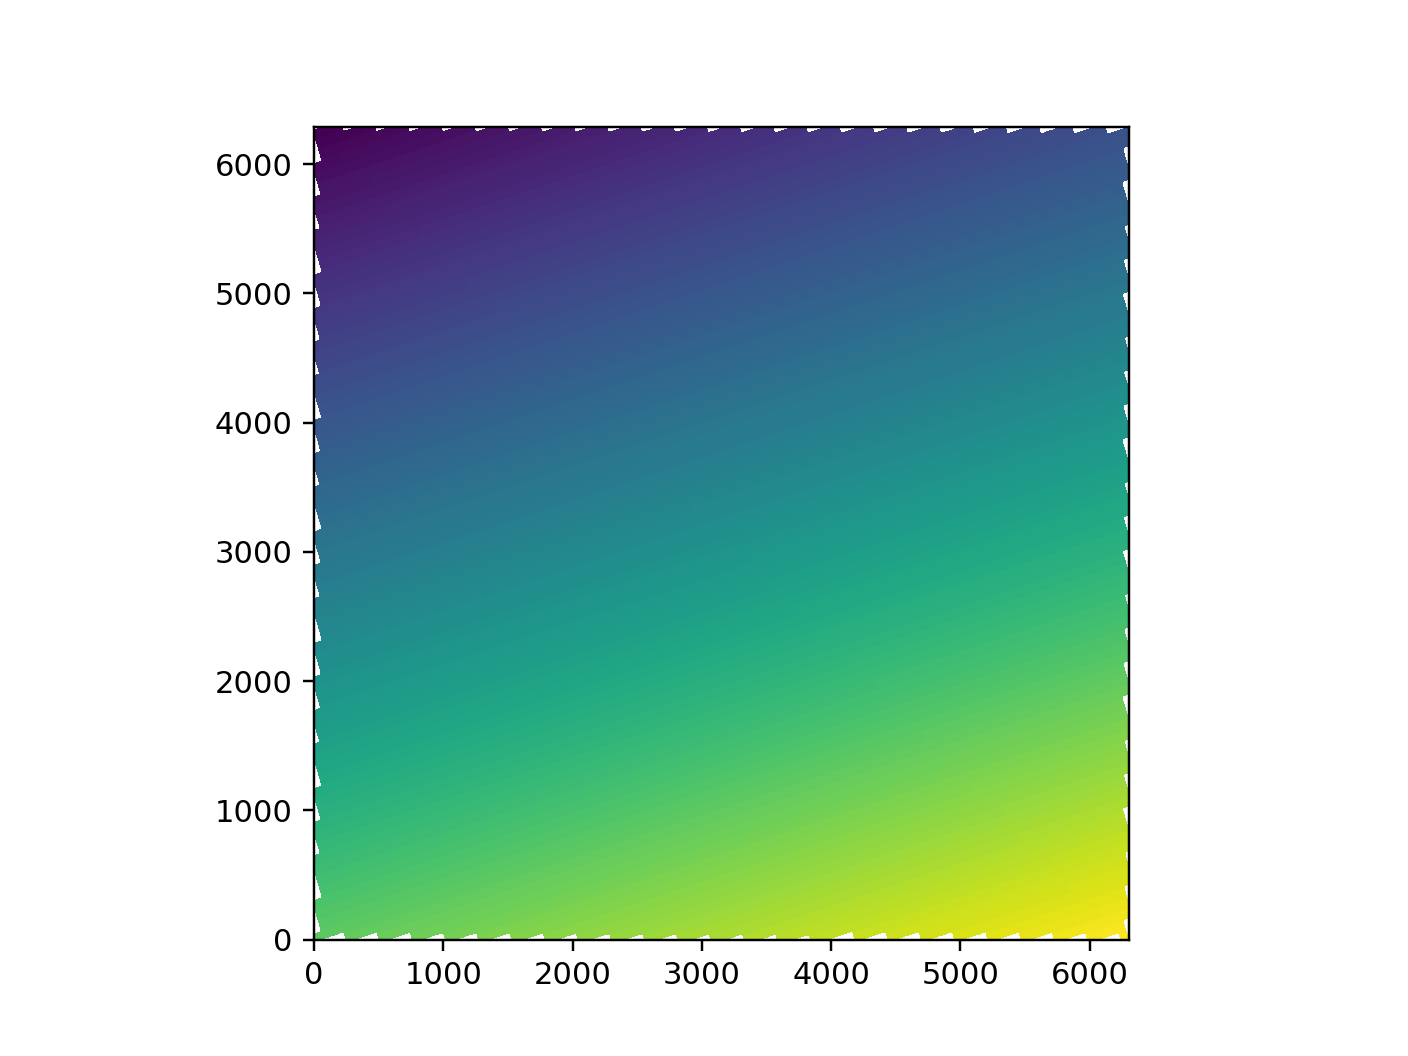

In [10]:
fll = np.full(np.shape(ps1_data), np.nan)

for i in range(len(pix_output)):
    unravel_index = np.unravel_index(pix_output[i][-1], np.shape(ps1_data))
    print(unravel_index)
    # break
    fll[unravel_index] = pix_output[i][0]

plt.figure()
plt.imshow(fll, origin='lower', vmin = np.nanmin(fll), vmax = np.nanmax(fll))
plt.savefig('output.png')
plt.show()

In [11]:
np.save('test_assignment.npy',fll)

In [ ]:
# start = time.time()

# pix_output2 = []

# tess_pix_payload = [(i,etp) for (i,etp) in enumerate(enc_tess_pix)]
# for tess_pix_obj in tess_pix_payload:
    
#     tess_pix_index = tess_pix_obj[0]
#     tess_pix_moc = tess_pix_obj[1]
#     tp = enc_tess_pix_vertices[tess_pix_index]

#     _min_ra = np.min([v[0] for v in tp])-0.01
#     _max_ra = np.max([v[0] for v in tp])+0.01

#     _min_dec = np.min([v[1] for v in tp])-0.01
#     _max_dec = np.max([v[1] for v in tp])+0.01

#     search_indices = np.where(np.logical_and(((_ra2 <= _max_ra) & (_ra2 >= _min_ra)), 
#                                              ((_dec2 <= _max_dec) & (_dec2 >= _min_dec))))[0]

#     enc_ps1_pix_mask = tess_pix_moc.contains_lonlat(_ra2[search_indices]*u.degree, _dec2[search_indices]*u.degree)

#     pix_output2.append((tess_pix_index, np.asarray(_ra2[search_indices])[enc_ps1_pix_mask], np.asarray(_dec2[search_indices])[enc_ps1_pix_mask]))
    

# print("\n Length of output: %s" % len(pix_output))
# print('\nTime taken:', time.time() - start)

In [ ]:
start = time.time()

# Plot this for a random TESS pixel ('index_of_pix')

fig = plt.figure(111, figsize=(10, 10))

outer_index_of_pix = 1254
print("Outer index: %s" % outer_index_of_pix)



_enc_ps1_pix = pix_output[outer_index_of_pix]

index_of_pix = _enc_ps1_pix[0]
print("Inner index: %s" % index_of_pix)

_enc_ras = _enc_ps1_pix[1]
_enc_decs = _enc_ps1_pix[2]

# print(_enc_ras)
# print(_enc_decs)

# Define a astropy WCS easily
with mocWCS(
    fig,
    fov=0.008 * u.degree,
    center=SkyCoord(enc_tess_pix_center_ra[index_of_pix], enc_tess_pix_center_dec[index_of_pix], unit="deg", frame="icrs"), 
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    # The gnomonic projection transforms great circles into straight lines.
    projection="TAN"
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs) # wcs

    ps1_moc.border(ax=ax, wcs=wcs, alpha=1, color="green")
    
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    enc_tess_pix[index_of_pix].fill(ax=ax, wcs=wcs, alpha=1.0, fill=False, color="red", linewidth=1)

    
    for ___r, ___d in zip(_enc_ras, _enc_decs):
        ax.plot(___r, ___d, 'x', color="blue", markersize=1, transform=ax.get_transform("world"))
    

plt.xlabel("ra")
plt.ylabel("dec")
plt.title("TESS Pixel")
plt.grid(color="black", linestyle="dotted")
plt.show()

print('\nTime taken:', time.time() - start)

In [ ]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [ ]:

start = time.time()

# Plot this for a random TESS pixel ('index_of_pix')

fig = plt.figure(111, figsize=(15, 15))

indices = np.arange(20)
cmap = get_cmap(len(indices))


# get center
avg_ra=0
avg_dec=0
for _ii in indices:

    outer_index_of_pix = _ii
    _enc_ps1_pix = pix_output[outer_index_of_pix]
    index_of_pix = _enc_ps1_pix[0]
    _enc_ras = _enc_ps1_pix[1]
    _enc_decs = _enc_ps1_pix[2]

    

    avg_ra+=(np.average(_enc_ras)/len(indices))
    avg_dec+=(np.average(_enc_decs)/len(indices))

# Define a astropy WCS easily
with mocWCS(
    fig,
    fov=0.0025 * len(indices) * u.degree,
    center=SkyCoord(avg_ra, avg_dec, unit="deg", frame="icrs"), 
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    # The gnomonic projection transforms great circles into straight lines.
    projection="TAN"
) as wcs:

    ax = fig.add_subplot(1, 1, 1, projection=wcs) # wcs
    ps1_moc.border(ax=ax, wcs=wcs, alpha=1, color="green")
        
    for _ii in indices:
    
        outer_index_of_pix = _ii
        print("Outer index: %s" % outer_index_of_pix)
        
        _enc_ps1_pix = pix_output[outer_index_of_pix]
        
        index_of_pix = _enc_ps1_pix[0]
        print("Inner index: %s" % index_of_pix)
        
        _enc_ras = _enc_ps1_pix[1]
        _enc_decs = _enc_ps1_pix[2]
        
        # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
        # enc_tess_pix[index_of_pix].fill(ax=ax, wcs=wcs, alpha=1.0, fill=False, color="red", linewidth=1)
        enc_tess_pix[index_of_pix].border(ax=ax, wcs=wcs, alpha=1.0, fill=False, color="black", linewidth=1)

        clr = cmap(_ii)
        for ___r, ___d in zip(_enc_ras, _enc_decs):
            ax.plot(___r, ___d, ',', color=clr, markersize=10, transform=ax.get_transform("world"))
    

plt.xlabel("ra")
plt.ylabel("dec")
plt.title("TESS Pixel")
plt.grid(color="gray", linestyle="--")
plt.savefig('./tess/TESS_diagnostic.png', dpi=600, bbox_inches = 'tight')

plt.show()

print('\nTime taken:', time.time() - start)

In [ ]:
# pprint(pix_output)
# # pprint(pix_output[5:6])
print(len(enc_tess_pix))

tot = 0
for p in pix_output:
    tot += len(p[1])

print(tot)

print(len(_ra2))


# 39897855
# 39664723

In [ ]:
print(pix_output[4678])

In [ ]:
with open("./tess/pix_output_list_new.pkl", 'wb') as handle:
    pickle.dump(pix_output, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
np.shape(tess_data)

In [ ]:
np.shape(ps1_data)